In [5]:
import yaml

with open("config/visualization.yaml", "r") as f:
    data = yaml.safe_load(f)

In [6]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

In [7]:
from typing_extensions import TypedDict
from typing import Any

class VizState(TypedDict):
    user_question: str
    decision: str
    model_output: str
    result: Any

In [8]:
def decision(state: VizState):
    prompt = data['prompts']['decision'].format(user_question=state['user_question'], answer=state['model_output'])
    decision = llm.invoke(prompt).content
    state['decision'] = decision
    return state

def decision_router(state: VizState):
    if state['decision'] == 'chart':
        return "chart"
    elif state['decision'] == 'text':
        return "text"
    else:
        return "again"
    
def gen_text(state: VizState):
    prompt = data['prompts']['text'].format(user_question=state['user_question'], answer=state['model_output'])
    response = llm.invoke(prompt)
    state['result'] = response.content
    return state

def gen_chart(state: VizState):
    prompt = data['prompts']['chart'].format(user_question=state['user_question'], answer=state['model_output'])
    response = llm.invoke(prompt).content
    print(response)
    return state

In [9]:
from langgraph.graph import StateGraph, START, END

graph = StateGraph(VizState)
graph.add_node("decision_maker", decision)
graph.add_node("text_generator", gen_text)
graph.add_node("chart_generator", gen_chart)

graph.add_edge(START, "decision_maker")
graph.add_conditional_edges("decision_maker",
    decision_router,
    {
        "chart": "chart_generator",
        "text": "text_generator",
        "again": "decision_maker"
    }
)
graph.add_edge("chart_generator", END)
graph.add_edge("text_generator", END)

app = graph.compile()

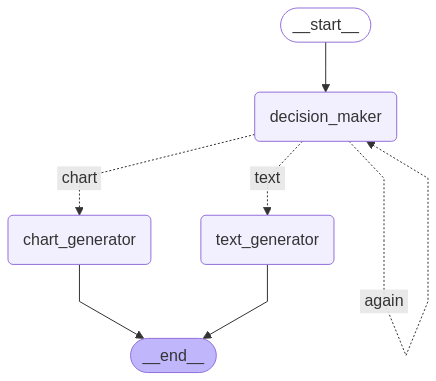

In [10]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

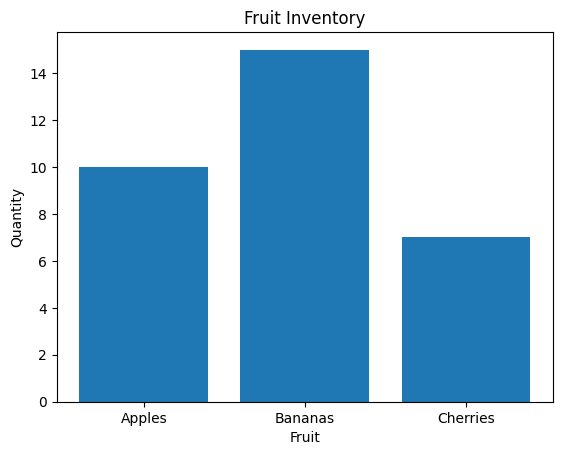

In [2]:
import matplotlib.pyplot as plt

# Sample data
categories = ['Apples', 'Bananas', 'Cherries']
values = [10, 15, 7]

# Create bar chart
plt.bar(categories, values)

# Add labels and title
plt.xlabel('Fruit')
plt.ylabel('Quantity')
plt.title('Fruit Inventory')

# Show the chart
plt.show()